In [1]:
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
from scipy.stats import sem, norm, bootstrap
from my_utils import *
from sklearn.linear_model import RidgeCV

from pathlib import Path
import sys
import warnings
import pickle

In [2]:
modelpath = Path('../model')
sys.path.append(str(modelpath))
import config.config as config

In [3]:
# agents checkpoints path
progress_noise_hoagents_path = Path('../data/agents_all/Actor1Critic1/gain_control')
progress_noise_moagents_path = Path('../data/agents_all/Actor3Critic5/gain_control')
# agents checkpoints performance path
training_curve_path = Path('../data/training_curve')
# figure path
figure_path = Path('../paper_figures/figure7')
# data path
analysis_data_path = Path('../data/analysis_data/figure7')

# Gain task

## Select agent checkpoints for analyses

In [4]:
from Actor1 import Actor as Actor1; from Critic1 import Critic as Critic1
from Actor3 import Actor as Actor3; from Critic5 import Critic as Critic5

pro_stds = [str(i) for i in [0, 0.1, 0.2, 0.3]]; obs_stds = pro_stds.copy()
agent_noises = ['_'.join(list(i)) for i in cartesian_prod(pro_stds, obs_stds)]

In [5]:
def select_noise_agents(progress_agents_path, agent_noises, MAX_TRAINING_T, task='gain', arch='', condition='E'): 
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / f'{task}_control_full' / agent_noise).glob(f'{arch}_*')] 
             for agent_noise in agent_noises]
    
    agent_paths = []; agent_files = []
    for agent_noise, seeds_ in zip(agent_noises, seeds): # loop each agent
        agent_path = []; agent_file = []
        for seed in seeds_:
            perform_file_path = training_curve_path / f'{task}_control_full' / agent_noise / f'{arch}_seed{seed}.csv'
            perform_file = pd.read_csv(perform_file_path)
            perform_file = perform_file[(perform_file.episode > 0) & (perform_file.episode < MAX_TRAINING_T)]
            if 'gain' in task:
                best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                          for task in ['gain1x', 'gain2x']], axis=0).argmax()]
                if condition == 'H':
                    best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                          for task in perform_file.task.unique()], axis=0).argmax()]
            if 'pert' in task:
                best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                          for task in ['perturbation0', 'perturbation1']], axis=0).argmax()]
                if condition == 'H':
                    best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                          for task in perform_file.task.unique()], axis=0).argmax()]
            
            agent_path.append(progress_agents_path / agent_noise / f'seed{seed}')
            agent_file.append(list(agent_path[-1].glob(f'*-{best_episode}.*'))[0].stem.split('.')[0])
        agent_paths.append(agent_path); agent_files.append(agent_file)
    
    
    return agent_paths, agent_files

In [6]:
noise_hoagent_paths_gain, noise_hoagent_files_gain = select_noise_agents(progress_noise_hoagents_path, agent_noises, 
                                                                         MAX_TRAINING_T=1e4, task='gain', 
                                                                         arch='Actor1Critic1')
noise_moagent_paths_gain, noise_moagent_files_gain = select_noise_agents(progress_noise_moagents_path, agent_noises, 
                                                                         MAX_TRAINING_T=1e4, task='gain', 
                                                                         arch='Actor3Critic5')
noise_hoagent_paths_gain_L, noise_hoagent_files_gain_L = select_noise_agents(progress_noise_hoagents_path, agent_noises, 
                                                                             MAX_TRAINING_T=1e5, task='gain', 
                                                                             arch='Actor1Critic1')
noise_moagent_paths_gain_L, noise_moagent_files_gain_L = select_noise_agents(progress_noise_moagents_path, agent_noises, 
                                                                             MAX_TRAINING_T=1e5, task='gain', 
                                                                             arch='Actor3Critic5')
noise_hoagent_paths_gain_LH, noise_hoagent_files_gain_LH = select_noise_agents(progress_noise_hoagents_path, agent_noises, 
                                                                             MAX_TRAINING_T=1e5, task='gain', 
                                                                             arch='Actor1Critic1', condition='H')
noise_moagent_paths_gain_LH, noise_moagent_files_gain_LH = select_noise_agents(progress_noise_moagents_path, agent_noises, 
                                                                             MAX_TRAINING_T=1e5, task='gain', 
                                                                             arch='Actor3Critic5', condition='H')

## Run agents in the gain task

In [7]:
from Agent_RNN import *
from Environment import Env

In [8]:
def RNN_agent_simulation_gain(agent, target_positions, gains, arg):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []; pos_theta = []; pos_r_end = []; pos_theta_end = []; 
    pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    steps = []; state_ = []; action_ = []

    for target_position, gain in zip(target_positions, gains):
        cross_start_threshold = False
        x = env.reset(target_position=target_position, pro_gains=gain)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)

            true_states.append(x)
            states.append(state)
            actions.append(action)
            
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

            if is_stop and cross_start_threshold:
                break

        # Trial end
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))
        
        state_.append(torch.cat(states))

        action_.append(torch.cat(actions))
        action_v_temp, action_w_temp = torch.chunk(torch.cat(actions).squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())
        
        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))

    agent.bstep.obs_noise_range = config.ConfigGain().obs_noise_range
    
    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 steps=steps, gain_v=torch.stack(gains)[:, 0].numpy(),
                                 gain_w=torch.stack(gains)[:, 1].numpy(), 
                                 state=state_, action=action_))

In [9]:
SAMPLE_SIZE = 2000

reset_seeds(0)
arg = config.ConfigGain()
arg.device = 'cpu'
arg.process_gain_range = [2, 2.0001]
env = Env(arg)
gains = []

for _ in range(SAMPLE_SIZE):
    __ = env.reset()
    gains.append(env.pro_gains)
    
reset_seeds(0)
arg = config.ConfigGain()
arg.device = 'cpu'
arg.process_gain_range = [3, 4.0001]
env = Env(arg)
target_positions = []
gainsH = []

for _ in range(SAMPLE_SIZE):
    __ = env.reset()
    target_positions.append(env.target_position)
    gainsH.append(env.pro_gains)
    
gains_1x = [arg.process_gain_default for _ in gains]

### Running the following cells takes a lot of time, so I've saved the results. We can now simply load those results for analysis.

In [ ]:
'''
noise_hoagents_gain = []; noise_hoagent_trajectories_gain = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGainControl(pro_noise=float(agent_noise.split('_')[0]), 
                                   obs_noise=float(agent_noise.split('_')[1]))
    arg.device = 'cpu'
    arg.process_gain_range = [2, 2.0001]
    for agent_path, agent_file in zip(noise_hoagent_paths_gain[idx], noise_hoagent_files_gain[idx]):
        agent = Agent(arg, Actor1, Critic1)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation_gain(agent, target_positions, gains, arg))
    noise_hoagents_gain.append(agents_)
    noise_hoagent_trajectories_gain.append(agent_trajectories_)

noise_moagents_gain = []; noise_moagent_trajectories_gain = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGainControl(pro_noise=float(agent_noise.split('_')[0]), 
                                   obs_noise=float(agent_noise.split('_')[1]))
    arg.device = 'cpu'
    arg.process_gain_range = [2, 2.0001]
    for agent_path, agent_file in zip(noise_moagent_paths_gain[idx], noise_moagent_files_gain[idx]):
        from Agent_RNN import *
        agent = Agent(arg, Actor3, Critic5)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation_gain(agent, target_positions, gains, arg))
    noise_moagents_gain.append(agents_)
    noise_moagent_trajectories_gain.append(agent_trajectories_)
'''

In [ ]:
'''
noise_hoagents_gain_L = []; noise_hoagent_trajectories_gain_L = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGainControl(pro_noise=float(agent_noise.split('_')[0]), 
                                   obs_noise=float(agent_noise.split('_')[1]))
    arg.device = 'cpu'
    arg.process_gain_range = [2, 2.0001]
    for agent_path, agent_file in zip(noise_hoagent_paths_gain_L[idx], noise_hoagent_files_gain_L[idx]):
        agent = Agent(arg, Actor1, Critic1)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation_gain(agent, target_positions, gains, arg))
    noise_hoagents_gain_L.append(agents_)
    noise_hoagent_trajectories_gain_L.append(agent_trajectories_)
    
    
noise_moagents_gain_L = []; noise_moagent_trajectories_gain_L = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGainControl(pro_noise=float(agent_noise.split('_')[0]), 
                                   obs_noise=float(agent_noise.split('_')[1]))
    arg.device = 'cpu'
    arg.process_gain_range = [2, 2.0001]
    for agent_path, agent_file in zip(noise_moagent_paths_gain_L[idx], noise_moagent_files_gain_L[idx]):
        agent = Agent(arg, Actor3, Critic5)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation_gain(agent, target_positions, gains, arg))
    noise_moagents_gain_L.append(agents_)
    noise_moagent_trajectories_gain_L.append(agent_trajectories_)
'''

In [ ]:
'''
noise_hoagents_gain_LH = []; noise_hoagent_trajectories_gain_LH = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGainControl(pro_noise=float(agent_noise.split('_')[0]), 
                                   obs_noise=float(agent_noise.split('_')[1]))
    arg.device = 'cpu'
    arg.process_gain_range = [3, 4.0001]
    for agent_path, agent_file in zip(noise_hoagent_paths_gain_LH[idx], noise_hoagent_files_gain_LH[idx]):
        agent = Agent(arg, Actor1, Critic1)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation_gain(agent, target_positions, gainsH, arg))
    noise_hoagents_gain_LH.append(agents_)
    noise_hoagent_trajectories_gain_LH.append(agent_trajectories_)
    
    
noise_moagents_gain_LH = []; noise_moagent_trajectories_gain_LH = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigGainControl(pro_noise=float(agent_noise.split('_')[0]), 
                                   obs_noise=float(agent_noise.split('_')[1]))
    arg.device = 'cpu'
    arg.process_gain_range = [3, 4.0001]
    for agent_path, agent_file in zip(noise_moagent_paths_gain_LH[idx], noise_moagent_files_gain_LH[idx]):
        agent = Agent(arg, Actor3, Critic5)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation_gain(agent, target_positions, gainsH, arg))
    noise_moagents_gain_LH.append(agents_)
    noise_moagent_trajectories_gain_LH.append(agent_trajectories_)
'''

In [ ]:
'''
def compute_roc(dfs):
    targets = dfs[0][0][['target_x', 'target_y']].values
    shuffled_targets = targets.copy()
    rng = default_rng(1); rng.shuffle(shuffled_targets, axis=0)
    
    ydata_subjects = []; xdata_subjects = []
    for dfs_ in dfs:
        ydata_seeds = []; xdata_seeds = []
        for df in dfs_:
            ydata = []; xdata = []
            dr = np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - targets, axis=1)
            dr_shuffled = np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - shuffled_targets, axis=1) 
            hypo_reward_boundaries = np.arange(round(max(max(dr), max(dr_shuffled))) + 2)
            for reward_boundary in hypo_reward_boundaries:
                ydata.append((dr < reward_boundary).sum() / len(df))
                xdata.append((dr_shuffled < reward_boundary).sum() / len(df))
            ydata_seeds.append(ydata); xdata_seeds.append(xdata)
        ydata_subjects.append(ydata_seeds); xdata_subjects.append(xdata_seeds)
        
    auc_data = [[np.trapz(ydata_subjects[agent_idx][idx], xdata_subjects[agent_idx][idx]) 
                 for idx in range(len(dfs[agent_idx]))] for agent_idx in range(len(dfs))]
    auc_mean = np.array([np.mean(i) for i in auc_data]).reshape(len(obs_stds), len(pro_stds))
    auc_sem = np.array([sem(i) for i in auc_data]).reshape(len(obs_stds), len(pro_stds))
    
    return xdata_subjects, ydata_subjects, auc_data, auc_mean, auc_sem


_, _, auc_noise_gain_ho, auc_noise_gain_mean_ho, auc_noise_gain_sem_ho = compute_roc(noise_hoagent_trajectories_gain)
_, _, auc_noise_gain_mo, auc_noise_gain_mean_mo, auc_noise_gain_sem_mo = compute_roc(noise_moagent_trajectories_gain)
_, _, auc_noise_gain_ho_L, auc_noise_gain_mean_ho_L, auc_noise_gain_sem_ho_L = compute_roc(noise_hoagent_trajectories_gain_L)
_, _, auc_noise_gain_mo_L, auc_noise_gain_mean_mo_L, auc_noise_gain_sem_mo_L = compute_roc(noise_moagent_trajectories_gain_L)
_, _, auc_noise_gain_ho_LH, auc_noise_gain_mean_ho_LH, auc_noise_gain_sem_ho_LH = compute_roc(noise_hoagent_trajectories_gain_LH)
_, _, auc_noise_gain_mo_LH, auc_noise_gain_mean_mo_LH, auc_noise_gain_sem_mo_LH = compute_roc(noise_moagent_trajectories_gain_LH)
'''

In [15]:
'''
file_path = analysis_data_path / 'auc_noise_gain_ho.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_gain_ho, file)
    
file_path = analysis_data_path / 'auc_noise_gain_mo.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_gain_mo, file)
    
file_path = analysis_data_path / 'auc_noise_gain_ho_L.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_gain_ho_L, file)
    
file_path = analysis_data_path / 'auc_noise_gain_mo_L.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_gain_mo_L, file)
    
file_path = analysis_data_path / 'auc_noise_gain_ho_LH.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_gain_ho_LH, file)
    
file_path = analysis_data_path / 'auc_noise_gain_mo_LH.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_gain_mo_LH, file)
'''

In [10]:
file_path = analysis_data_path / 'auc_noise_gain_ho.pkl'
with open(file_path, 'rb') as file:
    auc_noise_gain_ho = pickle.load(file)
    
file_path = analysis_data_path / 'auc_noise_gain_mo.pkl'
with open(file_path, 'rb') as file:
    auc_noise_gain_mo = pickle.load(file)
    
file_path = analysis_data_path / 'auc_noise_gain_ho_L.pkl'
with open(file_path, 'rb') as file:
    auc_noise_gain_ho_L = pickle.load(file)
    
file_path = analysis_data_path / 'auc_noise_gain_mo_L.pkl'
with open(file_path, 'rb') as file:
    auc_noise_gain_mo_L = pickle.load(file)
    
file_path = analysis_data_path / 'auc_noise_gain_ho_LH.pkl'
with open(file_path, 'rb') as file:
    auc_noise_gain_ho_LH = pickle.load(file)
    
file_path = analysis_data_path / 'auc_noise_gain_mo_LH.pkl'
with open(file_path, 'rb') as file:
    auc_noise_gain_mo_LH = pickle.load(file)
    
auc_noise_gain_mean_ho = np.array([np.mean(v) for v in auc_noise_gain_ho]).reshape(len(obs_stds), len(pro_stds))
auc_noise_gain_mean_mo = np.array([np.mean(v) for v in auc_noise_gain_mo]).reshape(len(obs_stds), len(pro_stds))
auc_noise_gain_mean_ho_L = np.array([np.mean(v) for v in auc_noise_gain_ho_L]).reshape(len(obs_stds), len(pro_stds))
auc_noise_gain_mean_mo_L = np.array([np.mean(v) for v in auc_noise_gain_mo_L]).reshape(len(obs_stds), len(pro_stds))
auc_noise_gain_mean_ho_LH = np.array([np.mean(v) for v in auc_noise_gain_ho_LH]).reshape(len(obs_stds), len(pro_stds))
auc_noise_gain_mean_mo_LH = np.array([np.mean(v) for v in auc_noise_gain_mo_LH]).reshape(len(obs_stds), len(pro_stds))

## Figures

In [11]:
locals().update(config_colors())
major_formatter = FuncFormatter(my_tickformatter)

fontsize = 7
lw = 1

## 7b

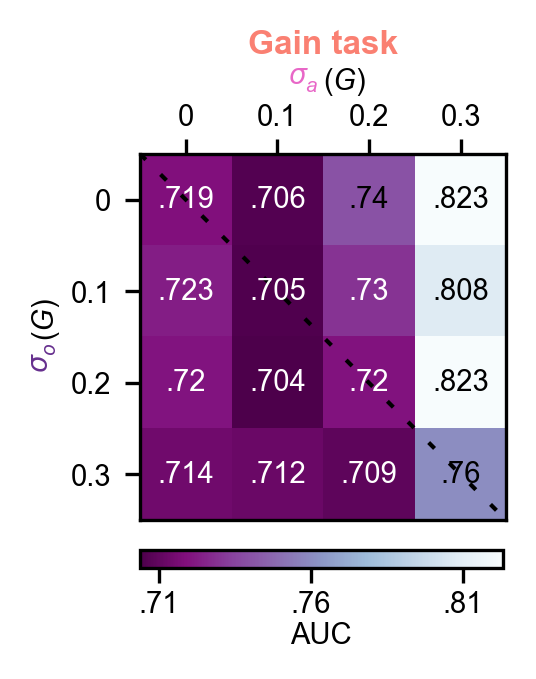

In [13]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = auc_noise_gain_mean_ho

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Gain task', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.71, 0.76, 0.81]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    #rect = Rectangle(xy=(1.5, 0.5), width=1, height=1, fill=False, ec='k', lw=1)
    #ax.add_patch(rect)
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_gain_ho'), orientation='portrait', format='pdf', transparent=True)

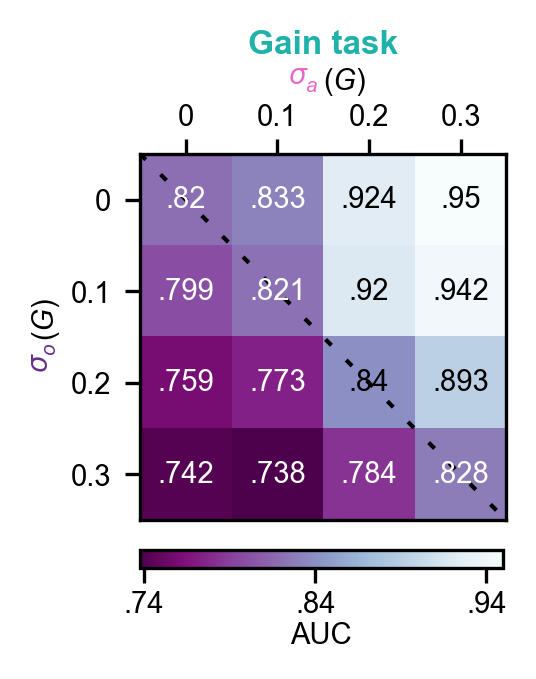

In [14]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = auc_noise_gain_mean_mo

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Gain task', fontsize=fontsize + 1, fontweight='bold', pad=3, c=modular_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.74, 0.84, 0.94]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    #rect = Rectangle(xy=(1.5, 0.5), width=1, height=1, fill=False, ec='k', lw=1)
    #ax.add_patch(rect)
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_gain_mo'), orientation='portrait', format='pdf', transparent=True)

## S7b

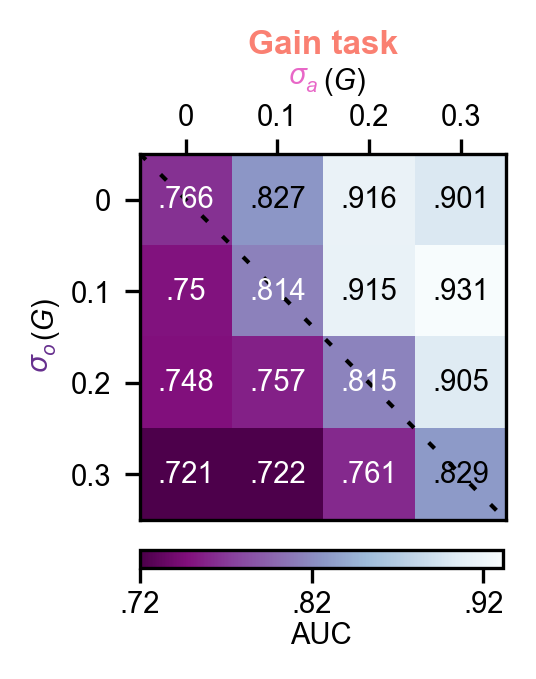

In [15]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = auc_noise_gain_mean_ho_L

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Gain task', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.72, 0.82, 0.92]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    #rect = Rectangle(xy=(1.5, 0.5), width=1, height=1, fill=False, ec='k', lw=1)
    #ax.add_patch(rect)
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_gain_ho_L'), orientation='portrait', format='pdf', transparent=True)

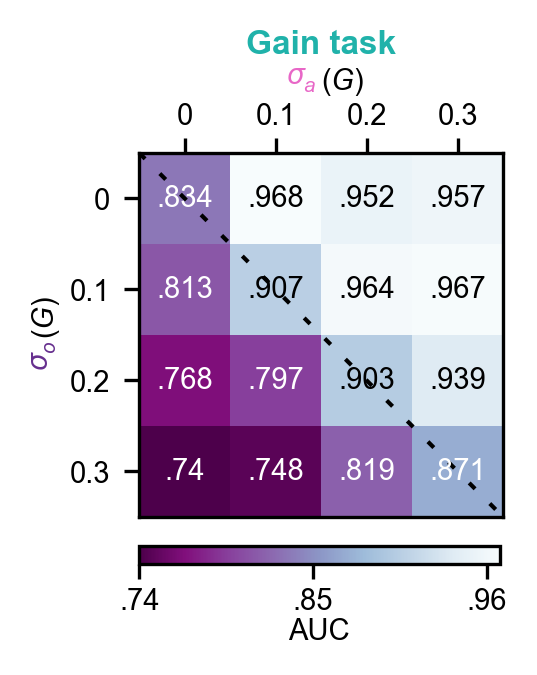

In [16]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = auc_noise_gain_mean_mo_L

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Gain task', fontsize=fontsize + 1, fontweight='bold', pad=3, c=modular_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.74, 0.85, 0.96]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    #rect = Rectangle(xy=(1.5, 0.5), width=1, height=1, fill=False, ec='k', lw=1)
    #ax.add_patch(rect)
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_gain_mo_L'), orientation='portrait', format='pdf', transparent=True)

## 7a

### Running the following cells takes a lot of time, so I've saved the results. We can now simply load those results for analysis.

In [17]:
def compute_roc_df(df):
    targets = df[['target_x', 'target_y']].values
    shuffled_targets = targets.copy()
    rng = default_rng(1); rng.shuffle(shuffled_targets, axis=0)
    
    ydata = []; xdata = []
    dr = np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - targets, axis=1)
    dr_shuffled = np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - shuffled_targets, axis=1) 
    hypo_reward_boundaries = np.arange(round(max(max(dr), max(dr_shuffled))) + 2)
    for reward_boundary in hypo_reward_boundaries:
        ydata.append((dr < reward_boundary).sum() / len(df))
        xdata.append((dr_shuffled < reward_boundary).sum() / len(df))
        
    auc = np.trapz(ydata, xdata)
    return auc

In [ ]:
'''
arg = config.ConfigGain()
arg.device = 'cpu'    
auc_noise_train_ho = []
for idx, agent_noise in enumerate(agent_noises):
    pro_test, obs_test = np.array(agent_noise.split('_')).astype('float')
    pro_test = np.arange(pro_test, pro_test + 1, 0.2)
    obs_test = np.arange(obs_test, obs_test + 1, 0.2)
    agent_noises_test = cartesian_prod(pro_test, obs_test)
    
    auc_noise_test = []
    for agent_noise_test in agent_noises_test:
        #print(agent_noise, agent_noise_test)
        arg.pro_noise_range = [agent_noise_test[0]] * 2
        arg.obs_noise_range = [agent_noise_test[1]] * 2
        
        auc_seeds = []
        for agent_path, agent_file in zip(noise_hoagent_paths_gain[idx], noise_hoagent_files_gain[idx]):
            agent = Agent(arg, Actor1, Critic1)
            agent.data_path = agent_path
            agent.load(agent_file, load_memory=False, load_optimzer=False)
            df = RNN_agent_simulation_gain(agent, target_positions, gains_1x, arg)
            auc_seeds.append(compute_roc_df(df))
        auc_noise_test.append(auc_seeds)
    auc_noise_train_ho.append(auc_noise_test) 
'''

In [ ]:
'''
arg = config.ConfigGain()
arg.device = 'cpu'    
auc_noise_train_mo = []
for idx, agent_noise in enumerate(agent_noises):
    pro_test, obs_test = np.array(agent_noise.split('_')).astype('float')
    pro_test = np.arange(pro_test, pro_test + 1, 0.2)
    obs_test = np.arange(obs_test, obs_test + 1, 0.2)
    agent_noises_test = cartesian_prod(pro_test, obs_test)
    
    auc_noise_test = []
    for agent_noise_test in agent_noises_test:
        #print(agent_noise, agent_noise_test)
        arg.pro_noise_range = [agent_noise_test[0]] * 2
        arg.obs_noise_range = [agent_noise_test[1]] * 2
        
        auc_seeds = []
        for agent_path, agent_file in zip(noise_moagent_paths_gain[idx], noise_moagent_files_gain[idx]):
            agent = Agent(arg, Actor3, Critic5)
            agent.data_path = agent_path
            agent.load(agent_file, load_memory=False, load_optimzer=False)
            df = RNN_agent_simulation_gain(agent, target_positions, gains_1x, arg)
            auc_seeds.append(compute_roc_df(df))
        auc_noise_test.append(auc_seeds)
    auc_noise_train_mo.append(auc_noise_test)
'''

In [ ]:
'''
arg = config.ConfigGain()
arg.device = 'cpu'    
auc_noise_train_ho_L = []
for idx, agent_noise in enumerate(agent_noises):
    pro_test, obs_test = np.array(agent_noise.split('_')).astype('float')
    pro_test = np.arange(pro_test, pro_test + 1, 0.2)
    obs_test = np.arange(obs_test, obs_test + 1, 0.2)
    agent_noises_test = cartesian_prod(pro_test, obs_test)
    
    auc_noise_test = []
    for agent_noise_test in agent_noises_test:
        #print(agent_noise, agent_noise_test)
        arg.pro_noise_range = [agent_noise_test[0]] * 2
        arg.obs_noise_range = [agent_noise_test[1]] * 2
        
        auc_seeds = []
        for agent_path, agent_file in zip(noise_hoagent_paths_gain_L[idx], noise_hoagent_files_gain_L[idx]):
            agent = Agent(arg, Actor1, Critic1)
            agent.data_path = agent_path
            agent.load(agent_file, load_memory=False, load_optimzer=False)
            df = RNN_agent_simulation_gain(agent, target_positions, gains_1x, arg)
            auc_seeds.append(compute_roc_df(df))
        auc_noise_test.append(auc_seeds)
    auc_noise_train_ho_L.append(auc_noise_test)
'''

In [ ]:
'''
arg = config.ConfigGain()
arg.device = 'cpu'    
auc_noise_train_mo_L = []
for idx, agent_noise in enumerate(agent_noises):
    pro_test, obs_test = np.array(agent_noise.split('_')).astype('float')
    pro_test = np.arange(pro_test, pro_test + 1, 0.2)
    obs_test = np.arange(obs_test, obs_test + 1, 0.2)
    agent_noises_test = cartesian_prod(pro_test, obs_test)
    
    auc_noise_test = []
    for agent_noise_test in agent_noises_test:
        #print(agent_noise, agent_noise_test)
        arg.pro_noise_range = [agent_noise_test[0]] * 2
        arg.obs_noise_range = [agent_noise_test[1]] * 2
        
        auc_seeds = []
        for agent_path, agent_file in zip(noise_moagent_paths_gain_L[idx], noise_moagent_files_gain_L[idx]):
            agent = Agent(arg, Actor3, Critic5)
            agent.data_path = agent_path
            agent.load(agent_file, load_memory=False, load_optimzer=False)
            df = RNN_agent_simulation_gain(agent, target_positions, gains_1x, arg)
            auc_seeds.append(compute_roc_df(df))
        auc_noise_test.append(auc_seeds)
    auc_noise_train_mo_L.append(auc_noise_test)
'''

In [33]:
'''
file_path = analysis_data_path / 'auc_noise_train_ho.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_train_ho, file)
    
file_path = analysis_data_path / 'auc_noise_train_mo.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_train_mo, file)
    
file_path = analysis_data_path / 'auc_noise_train_ho_L.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_train_ho_L, file)
    
file_path = analysis_data_path / 'auc_noise_train_mo_L.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_train_mo_L, file)
'''

In [18]:
file_path = analysis_data_path / 'auc_noise_train_ho.pkl'
with open(file_path, 'rb') as file:
    auc_noise_train_ho = pickle.load(file)
    
file_path = analysis_data_path / 'auc_noise_train_mo.pkl'
with open(file_path, 'rb') as file:
    auc_noise_train_mo = pickle.load(file)
    
file_path = analysis_data_path / 'auc_noise_train_ho_L.pkl'
with open(file_path, 'rb') as file:
    auc_noise_train_ho_L = pickle.load(file)
    
file_path = analysis_data_path / 'auc_noise_train_mo_L.pkl'
with open(file_path, 'rb') as file:
    auc_noise_train_mo_L = pickle.load(file)

In [19]:
auc_holistic_mean_ho = [[np.mean(v_) for v_ in v] for v in auc_noise_train_ho]
auc_holistic_mean_mo = [[np.mean(v_) for v_ in v] for v in auc_noise_train_mo]
auc_holistic_mean_ho_L = [[np.mean(v_) for v_ in v] for v in auc_noise_train_ho_L]
auc_holistic_mean_mo_L = [[np.mean(v_) for v_ in v] for v in auc_noise_train_mo_L]

In [20]:
file_path = analysis_data_path.parent / 'figure2' / 'auc_EKF.pkl'
with open(file_path, 'rb') as file:
    auc_EKF = pickle.load(file)
    
file_path = analysis_data_path.parent / 'figure2' / 'auc_EKF_control.pkl'
with open(file_path, 'rb') as file:
    auc_EKF_control = pickle.load(file)

In [21]:
auc_EKF_mean = [np.mean(v) for v in auc_EKF]
auc_EKF_control_mean = [np.mean(v) for v in auc_EKF_control]

In [22]:
corr_ho_EKF = np.array([np.corrcoef(v, auc_EKF_mean)[0, 1] for v in auc_holistic_mean_ho])
corr_mo_EKF = np.array([np.corrcoef(v, auc_EKF_mean)[0, 1] for v in auc_holistic_mean_mo])
corr_ho_L_EKF = np.array([np.corrcoef(v, auc_EKF_mean)[0, 1] for v in auc_holistic_mean_ho_L])
corr_mo_L_EKF = np.array([np.corrcoef(v, auc_EKF_mean)[0, 1] for v in auc_holistic_mean_mo_L])

corr_ho_EKF_control = np.array([np.corrcoef(v, auc_EKF_control_mean)[0, 1] for v in auc_holistic_mean_ho])
corr_mo_EKF_control = np.array([np.corrcoef(v, auc_EKF_control_mean)[0, 1] for v in auc_holistic_mean_mo])
corr_ho_L_EKF_control = np.array([np.corrcoef(v, auc_EKF_control_mean)[0, 1] for v in auc_holistic_mean_ho_L])
corr_mo_L_EKF_control = np.array([np.corrcoef(v, auc_EKF_control_mean)[0, 1] for v in auc_holistic_mean_mo_L])

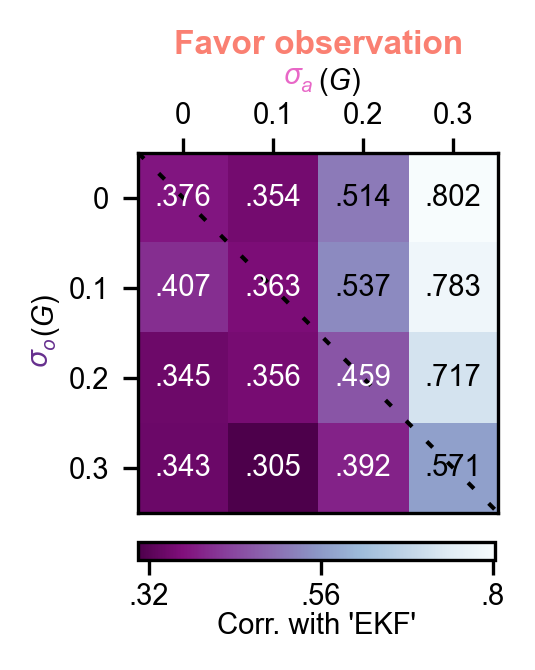

In [23]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = corr_ho_EKF.reshape(len(pro_stds), len(obs_stds))

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Favor observation', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.32, 0.56, 0.8]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label("Corr. with 'EKF'", fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='ho_EKF'), orientation='portrait', format='pdf', transparent=True)

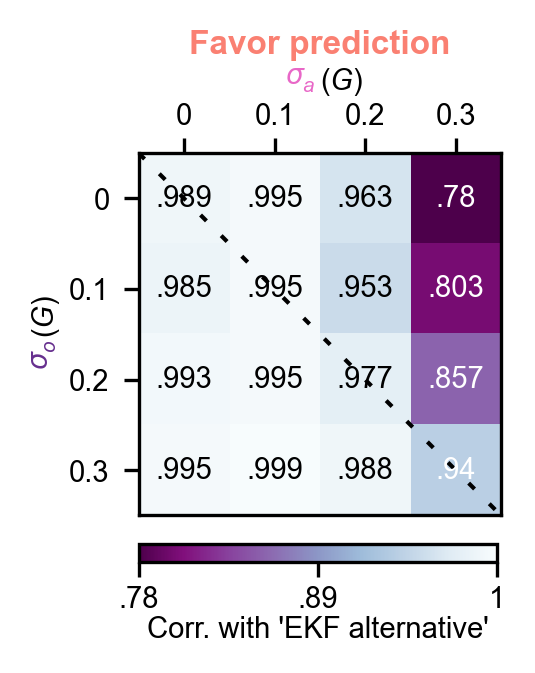

In [24]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = corr_ho_EKF_control.reshape(len(pro_stds), len(obs_stds))

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Favor prediction', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.78, 0.89, 1]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label("Corr. with 'EKF alternative'", fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='ho_EKF_alt'), orientation='portrait', format='pdf', transparent=True)

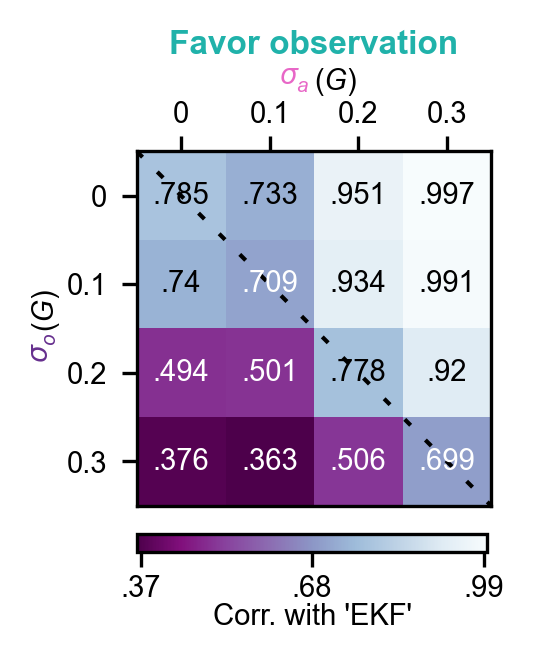

In [25]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = corr_mo_EKF.reshape(len(pro_stds), len(obs_stds))

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Favor observation', fontsize=fontsize + 1, fontweight='bold', pad=3, c=modular_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.37, 0.68, 0.99]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label("Corr. with 'EKF'", fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='mo_EKF'), orientation='portrait', format='pdf', transparent=True)

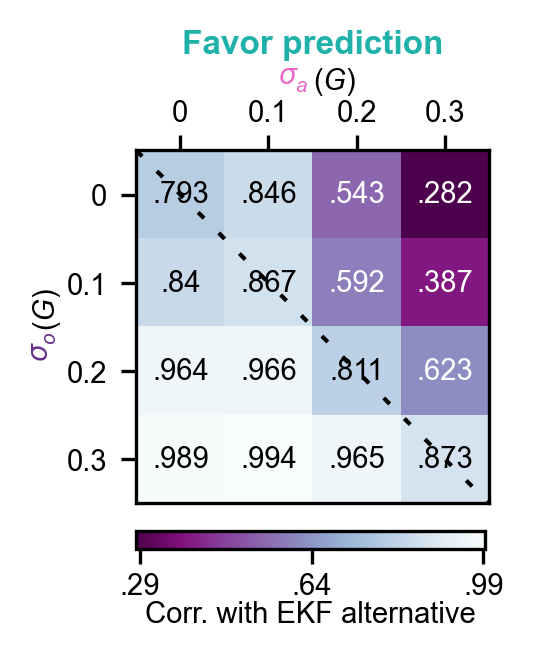

In [26]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = corr_mo_EKF_control.reshape(len(pro_stds), len(obs_stds))

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Favor prediction', fontsize=fontsize + 1, fontweight='bold', pad=3, c=modular_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.29, 0.64, 0.99]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label("Corr. with EKF alternative", fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='mo_EKF_alt'), orientation='portrait', format='pdf', transparent=True)

## S7a

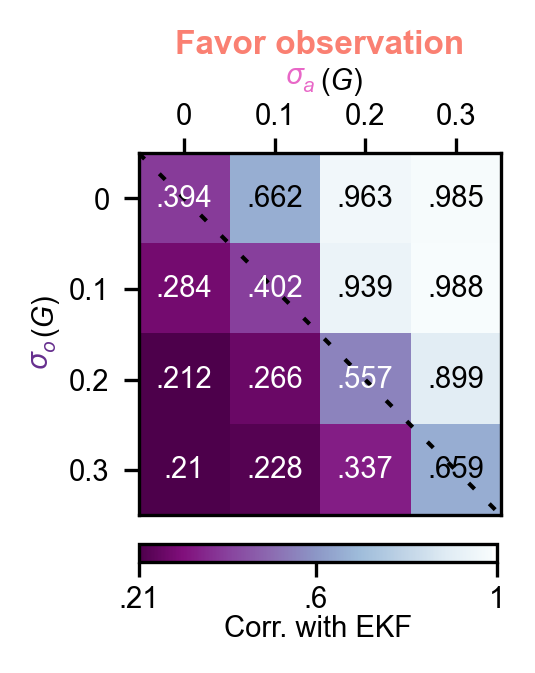

In [27]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = corr_ho_L_EKF.reshape(len(pro_stds), len(obs_stds))

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Favor observation', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.21, 0.6, 1]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label("Corr. with EKF", fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='hoL_EKF'), orientation='portrait', format='pdf', transparent=True)

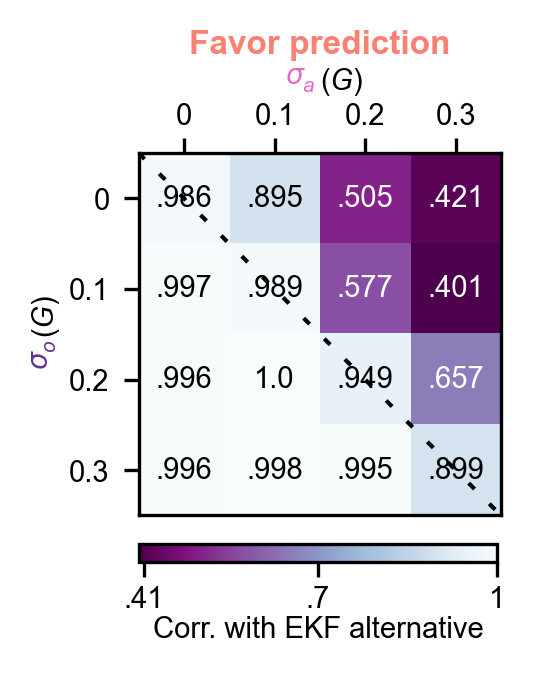

In [28]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = corr_ho_L_EKF_control.reshape(len(pro_stds), len(obs_stds))

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Favor prediction', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.41, 0.70, 1]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label("Corr. with EKF alternative", fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1] if v < 1 else str(v), fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='hoL_EKF_alt'), orientation='portrait', format='pdf', transparent=True)

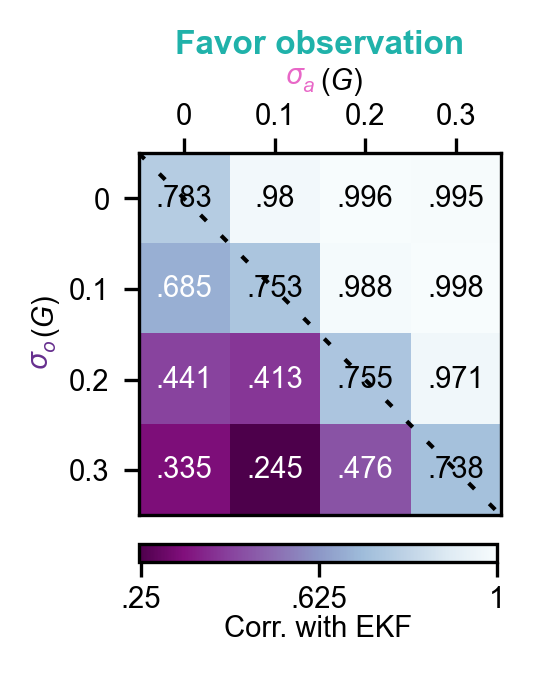

In [29]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = corr_mo_L_EKF.reshape(len(pro_stds), len(obs_stds))

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Favor observation', fontsize=fontsize + 1, fontweight='bold', pad=3, c=modular_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.25, 0.625, 1]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label("Corr. with EKF", fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='moL_EKF'), orientation='portrait', format='pdf', transparent=True)

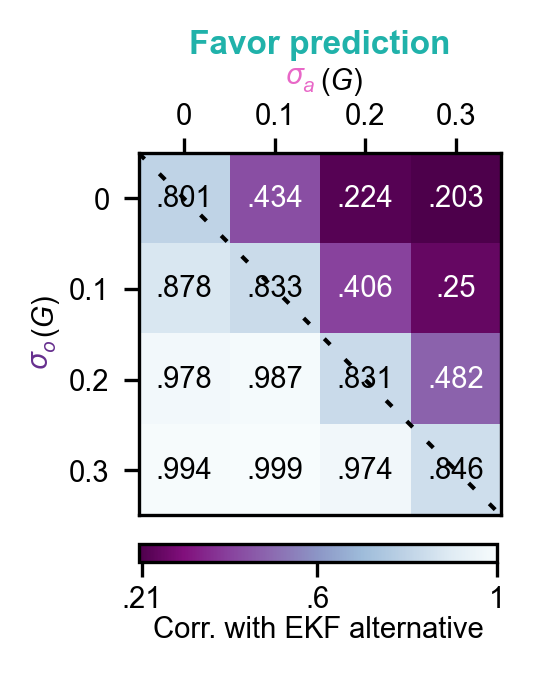

In [30]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = corr_mo_L_EKF_control.reshape(len(pro_stds), len(obs_stds))

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Favor prediction', fontsize=fontsize + 1, fontweight='bold', pad=3, c=modular_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.21, 0.60, 1]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label("Corr. with EKF alternative", fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='moL_EKF_alt'), orientation='portrait', format='pdf', transparent=True)

## S7c

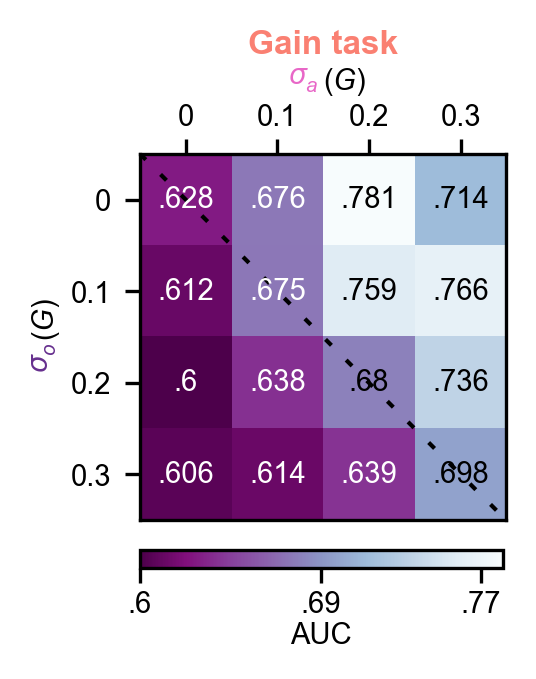

In [31]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = auc_noise_gain_mean_ho_LH

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Gain task', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.6, 0.69, 0.77]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    #rect = Rectangle(xy=(1.5, 0.5), width=1, height=1, fill=False, ec='k', lw=1)
    #ax.add_patch(rect)
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_gain_ho_LH'), orientation='portrait', format='pdf', transparent=True)

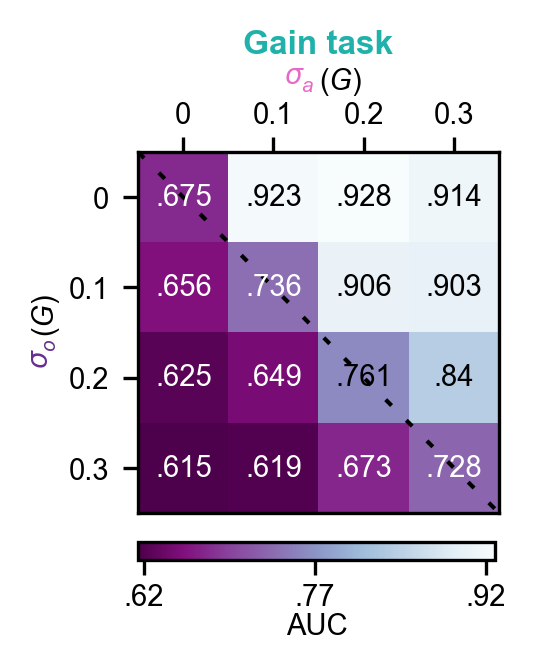

In [32]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = auc_noise_gain_mean_mo_LH

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Gain task', fontsize=fontsize + 1, fontweight='bold', pad=3, c=modular_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.62, 0.77, 0.92]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    #rect = Rectangle(xy=(1.5, 0.5), width=1, height=1, fill=False, ec='k', lw=1)
    #ax.add_patch(rect)
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_gain_mo_LH'), orientation='portrait', format='pdf', transparent=True)

## 7c-d

In [33]:
def bootstrap_corr(data1, data2):
    def my_pearsonr(x, y):
        return np.corrcoef(x, y)[0, 1]

    data1 = data1.reshape(-1)
    data2 = data2.reshape(-1)
    rng = np.random.default_rng(seed=0)
    data2_shuffle = data2.copy()
    rng.shuffle(data2_shuffle)
    
    res = bootstrap((data1, data2), my_pearsonr, paired=True, random_state=0, confidence_level=0.95)
    res_shuffle = bootstrap((data1, data2_shuffle), my_pearsonr, paired=True, random_state=0, confidence_level=0.95)
    return res, res_shuffle

In [34]:
res_ho_EKF, res_ho_EKF_shuffle = bootstrap_corr(auc_noise_gain_mean_ho, corr_ho_EKF)
res_ho_EKFA, res_ho_EKFA_shuffle = bootstrap_corr(auc_noise_gain_mean_ho, corr_ho_EKF_control)
res_mo_EKF, res_mo_EKF_shuffle = bootstrap_corr(auc_noise_gain_mean_mo, corr_mo_EKF)
res_mo_EKFA, res_mo_EKFA_shuffle = bootstrap_corr(auc_noise_gain_mean_mo, corr_mo_EKF_control)

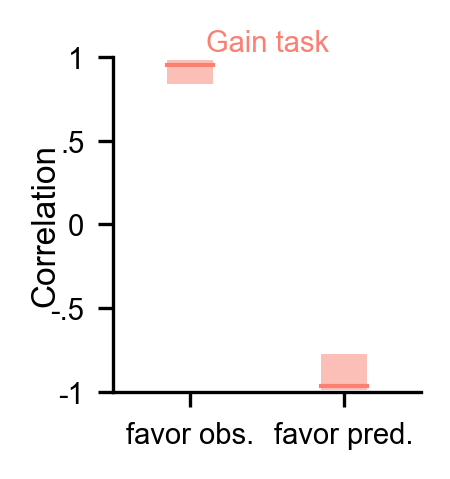

In [35]:
width = 1.3; height = 1.4
yticks = np.around(np.linspace(-1, 1, 5), 1)
ydata1 = [res_ho_EKF, res_ho_EKFA]
ydata2 = [res_ho_EKF_shuffle, res_ho_EKFA_shuffle]
colors = [holistic_c, holistic_c]

xticks = np.arange(2)
xticklabels = ['favor obs.', 'favor pred.']

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.set_title('Gain task', fontsize=fontsize, pad=0, c=holistic_c)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Correlation', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.17, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ydata, c in zip(xticks, ydata1, colors):
    ymean = ydata.bootstrap_distribution.mean()
    ax.plot([x-0.15, x+0.15], [ymean, ymean], c=c, lw=lw)
    ax.fill_between([x-0.15, x+0.15], [ydata.confidence_interval.low] * 2, [ydata.confidence_interval.high] * 2, 
                    facecolor=c, alpha=0.5)    
    
#ax.text(-0.2, 0, 'Shuffled', fontsize=fontsize - 0.5, c='gray')
    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='generalization_Kalman_ho'), orientation='portrait', format='pdf', transparent=True)

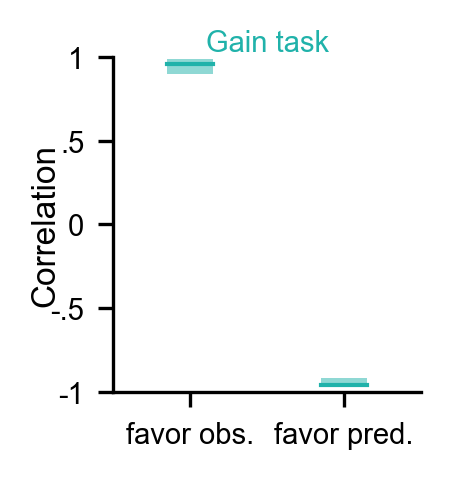

In [36]:
width = 1.3; height = 1.4
yticks = np.around(np.linspace(-1, 1, 5), 1)
ydata1 = [res_mo_EKF, res_mo_EKFA]
ydata2 = [res_mo_EKF_shuffle, res_mo_EKFA_shuffle]
colors = [modular_c, modular_c]

xticks = np.arange(2)
xticklabels = ['favor obs.', 'favor pred.']

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.set_title('Gain task', fontsize=fontsize, pad=0, c=modular_c)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Correlation', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.17, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ydata, c in zip(xticks, ydata1, colors):
    ymean = ydata.bootstrap_distribution.mean()
    ax.plot([x-0.15, x+0.15], [ymean, ymean], c=c, lw=lw)
    ax.fill_between([x-0.15, x+0.15], [ydata.confidence_interval.low] * 2, [ydata.confidence_interval.high] * 2, 
                    facecolor=c, alpha=0.5)    
    
#ax.text(-0.2, 0, 'Shuffled', fontsize=fontsize - 0.5, c='gray')
    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='generalization_Kalman_mo'), orientation='portrait', format='pdf', transparent=True)

# perturbation task

## Select agent checkpoints for analyses

In [12]:
noise_hoagent_paths_pert = noise_hoagent_paths_gain
noise_hoagent_files_pert = noise_hoagent_files_gain
noise_hoagent_paths_pert_L = noise_hoagent_paths_gain_L
noise_hoagent_files_pert_L = noise_hoagent_files_gain_L

noise_moagent_paths_pert = noise_moagent_paths_gain
noise_moagent_files_pert = noise_moagent_files_gain
noise_moagent_paths_pert_L = noise_moagent_paths_gain_L
noise_moagent_files_pert_L = noise_moagent_files_gain_L

noise_hoagent_paths_pert_LH, noise_hoagent_files_pert_LH = select_noise_agents(progress_noise_hoagents_path, agent_noises, 
                                                                             MAX_TRAINING_T=1e5, task='perturbation', 
                                                                             arch='Actor1Critic1', condition='H')
noise_moagent_paths_pert_LH, noise_moagent_files_pert_LH = select_noise_agents(progress_noise_moagents_path, agent_noises, 
                                                                             MAX_TRAINING_T=1e5, task='perturbation', 
                                                                             arch='Actor3Critic5', condition='H')

## Run agents in the perturbation task

In [13]:
def RNN_agent_simulation_pert(arg, agent, target_positions, perturb_peaks, perturb_start_time_oris):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range

    pos_x = []; pos_y = []; pos_x_end = []; pos_y_end = []; head_dir = []; head_dir_end = []; pos_r = []
    pos_theta = []; pos_r_end = []; pos_theta_end = []; pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []; steps = []
    perturb_v = []; perturb_w = []; perturb_v_gauss = []; perturb_w_gauss = []
    state_ = []; action_ = []

    for target_position, perturb_peak, perturb_start_time_ori in zip(target_positions, perturb_peaks,
                                                                     perturb_start_time_oris):
        cross_start_threshold = False
        x = env.reset(target_position=target_position, perturbation_velocities=perturb_peak,
                      perturbation_start_t=perturb_start_time_ori)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position.view(1, 1, -1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        perturbations = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
            
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)

            true_states.append(x)
            states.append(state)
            actions.append(action)
            perturbations.append(torch.stack((env.perturbation_vt, env.perturbation_wt)))
            
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

            if is_stop and cross_start_threshold:
                break

        # Trial end
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))
        
        state_.append(torch.cat(states))

        action_.append(torch.cat(actions))
        action_v_temp, action_w_temp = torch.chunk(torch.cat(actions).squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())
        
        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))
        
        perturb_v.append(torch.stack(perturbations)[:, 0].numpy() * arg.LINEAR_SCALE)
        perturb_w.append(np.rad2deg(torch.stack(perturbations)[:, 1].numpy()))
        perturb_v_gauss.append(env.gaussian_v_array.numpy() * arg.LINEAR_SCALE)
        perturb_w_gauss.append(np.rad2deg(env.gaussian_w_array.numpy()))
        
    agent.bstep.obs_noise_range = config.ConfigGain().obs_noise_range

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end, 
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end, steps=steps,
                                 perturb_v=perturb_v, perturb_w=perturb_w,
                                 perturb_vpeak=torch.stack(perturb_peaks)[:, 0].numpy() * arg.LINEAR_SCALE,
                                 perturb_wpeak=np.rad2deg(torch.stack(perturb_peaks)[:, 1].numpy()),
                                 perturb_start_time=torch.stack(perturb_start_time_oris).numpy(),
                                 perturb_v_gauss=perturb_v_gauss, perturb_w_gauss=perturb_w_gauss,
                                 gain_v=[env.process_gain_default[0].item() for _ in range(len(pos_x))],
                                 gain_w=[env.process_gain_default[1].item() for _ in range(len(pos_x))],
                                 state=state_, action=action_))

In [14]:
reset_seeds(0)
arg = config.ConfigPerturb(exclude_perturb=np.hstack([np.array([-100, 100]) / arg.LINEAR_SCALE, 
                                                      np.deg2rad([-60, 60])]))
arg.device = 'cpu'
env = Env(arg)
perturb_peaks = []; perturb_start_time = []
for _ in range(SAMPLE_SIZE):
    __ = env.reset()
    perturb_peaks.append(env.perturbation_velocities)
    perturb_start_time.append(env.perturbation_start_t * 0)
    
    
reset_seeds(0)
arg = config.ConfigPerturb(exclude_perturb=np.hstack([np.array([-100, 100]) / arg.LINEAR_SCALE, 
                                                      np.deg2rad([-60, 60])]))
arg.device = 'cpu'
arg.perturbation_velocity_range = arg.perturbation_velocity_range_large
env = Env(arg)
perturb_peaksH = []; perturb_start_timeH = []
for _ in range(SAMPLE_SIZE):
    __ = env.reset()
    perturb_peaksH.append(env.perturbation_velocities)
    perturb_start_timeH.append(env.perturbation_start_t)

### Running the following cells takes a lot of time, so I've saved the results. We can now simply load those results for analysis.

In [19]:
'''
noise_hoagents_pert = []; noise_hoagent_trajectories_pert = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigPerturbControl(pro_noise=float(agent_noise.split('_')[0]), 
                                      obs_noise=float(agent_noise.split('_')[1]))
    arg.device = 'cpu'
    for agent_path, agent_file in zip(noise_hoagent_paths_pert[idx], noise_hoagent_files_pert[idx]):
        agent = Agent(arg, Actor1, Critic1)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation_pert(arg, agent, target_positions, perturb_peaks, perturb_start_time))
    noise_hoagents_pert.append(agents_)
    noise_hoagent_trajectories_pert.append(agent_trajectories_)
'''

In [72]:
'''
noise_moagents_pert = []; noise_moagent_trajectories_pert = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigPerturbControl(pro_noise=float(agent_noise.split('_')[0]), 
                                      obs_noise=float(agent_noise.split('_')[1]))
    arg.device = 'cpu'
    for agent_path, agent_file in zip(noise_moagent_paths_pert[idx], noise_moagent_files_pert[idx]):
        agent = Agent(arg, Actor3, Critic5)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation_pert(arg, agent, target_positions, perturb_peaks, perturb_start_time))
    noise_moagents_pert.append(agents_)
    noise_moagent_trajectories_pert.append(agent_trajectories_)
'''

In [73]:
'''
noise_hoagents_pert_L = []; noise_hoagent_trajectories_pert_L = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigPerturbControl(pro_noise=float(agent_noise.split('_')[0]), 
                                      obs_noise=float(agent_noise.split('_')[1]))
    arg.device = 'cpu'
    for agent_path, agent_file in zip(noise_hoagent_paths_pert_L[idx], noise_hoagent_files_pert_L[idx]):
        agent = Agent(arg, Actor1, Critic1)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation_pert(arg, agent, target_positions, perturb_peaks, perturb_start_time))
    noise_hoagents_pert_L.append(agents_)
    noise_hoagent_trajectories_pert_L.append(agent_trajectories_)
'''

In [74]:
'''
noise_moagents_pert_L = []; noise_moagent_trajectories_pert_L = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigPerturbControl(pro_noise=float(agent_noise.split('_')[0]), 
                                      obs_noise=float(agent_noise.split('_')[1]))
    arg.device = 'cpu'
    for agent_path, agent_file in zip(noise_moagent_paths_pert_L[idx], noise_moagent_files_pert_L[idx]):
        agent = Agent(arg, Actor3, Critic5)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation_pert(arg, agent, target_positions, perturb_peaks, perturb_start_time))
    noise_moagents_pert_L.append(agents_)
    noise_moagent_trajectories_pert_L.append(agent_trajectories_)
'''

In [ ]:
'''
noise_hoagents_pert_LH = []; noise_hoagent_trajectories_pert_LH = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigPerturbControl(pro_noise=float(agent_noise.split('_')[0]), 
                                      obs_noise=float(agent_noise.split('_')[1]))
    arg.device = 'cpu'
    for agent_path, agent_file in zip(noise_hoagent_paths_pert_LH[idx], noise_hoagent_files_pert_LH[idx]):
        agent = Agent(arg, Actor1, Critic1)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation_pert(arg, agent, target_positions, perturb_peaksH, perturb_start_timeH))
    noise_hoagents_pert_LH.append(agents_)
    noise_hoagent_trajectories_pert_LH.append(agent_trajectories_)
'''

In [36]:
'''
noise_moagents_pert_LH = []; noise_moagent_trajectories_pert_LH = []
for idx, agent_noise in enumerate(agent_noises):
    agents_ = []; agent_trajectories_ = []
    arg = config.ConfigPerturbControl(pro_noise=float(agent_noise.split('_')[0]), 
                                      obs_noise=float(agent_noise.split('_')[1]))
    arg.device = 'cpu'
    arg.perturbation_velocity_range = arg.perturbation_velocity_range_large
    for agent_path, agent_file in zip(noise_moagent_paths_pert_LH[idx], noise_moagent_files_pert_LH[idx]):
        agent = Agent(arg, Actor3, Critic5)
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
        agent_trajectories_.append(RNN_agent_simulation_pert(arg, agent, target_positions, perturb_peaksH, perturb_start_timeH))
    noise_moagents_pert_LH.append(agents_)
    noise_moagent_trajectories_pert_LH.append(agent_trajectories_)
'''

In [37]:
'''
_, _, auc_noise_pert_ho, auc_noise_pert_mean_ho, auc_noise_pert_sem_ho = compute_roc(noise_hoagent_trajectories_pert)
_, _, auc_noise_pert_mo, auc_noise_pert_mean_mo, auc_noise_pert_sem_mo = compute_roc(noise_moagent_trajectories_pert)
_, _, auc_noise_pert_ho_L, auc_noise_pert_mean_ho_L, auc_noise_pert_sem_ho_L = compute_roc(noise_hoagent_trajectories_pert_L)
_, _, auc_noise_pert_mo_L, auc_noise_pert_mean_mo_L, auc_noise_pert_sem_mo_L = compute_roc(noise_moagent_trajectories_pert_L)
_, _, auc_noise_pert_ho_LH, auc_noise_pert_mean_ho_LH, auc_noise_pert_sem_ho_LH = compute_roc(noise_hoagent_trajectories_pert_LH)
_, _, auc_noise_pert_mo_LH, auc_noise_pert_mean_mo_LH, auc_noise_pert_sem_mo_LH = compute_roc(noise_moagent_trajectories_pert_LH)
'''

In [ ]:
'''
file_path = analysis_data_path / 'auc_noise_pert_ho.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_pert_ho, file)
    
file_path = analysis_data_path / 'auc_noise_pert_mo.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_pert_mo, file)
    
file_path = analysis_data_path / 'auc_noise_pert_ho_L.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_pert_ho_L, file)
    
file_path = analysis_data_path / 'auc_noise_pert_mo_L.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_pert_mo_L, file)
   
file_path = analysis_data_path / 'auc_noise_pert_ho_LH.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_pert_ho_LH, file)
    
file_path = analysis_data_path / 'auc_noise_pert_mo_LH.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(auc_noise_pert_mo_LH, file)
'''

In [15]:
file_path = analysis_data_path / 'auc_noise_pert_ho.pkl'
with open(file_path, 'rb') as file:
    auc_noise_pert_ho = pickle.load(file)
    
file_path = analysis_data_path / 'auc_noise_pert_mo.pkl'
with open(file_path, 'rb') as file:
    auc_noise_pert_mo = pickle.load(file)
    
file_path = analysis_data_path / 'auc_noise_pert_ho_L.pkl'
with open(file_path, 'rb') as file:
    auc_noise_pert_ho_L = pickle.load(file)
    
file_path = analysis_data_path / 'auc_noise_pert_mo_L.pkl'
with open(file_path, 'rb') as file:
    auc_noise_pert_mo_L = pickle.load(file)
    
file_path = analysis_data_path / 'auc_noise_pert_ho_LH.pkl'
with open(file_path, 'rb') as file:
    auc_noise_pert_ho_LH = pickle.load(file)
    
file_path = analysis_data_path / 'auc_noise_pert_mo_LH.pkl'
with open(file_path, 'rb') as file:
    auc_noise_pert_mo_LH = pickle.load(file)
    
auc_noise_pert_mean_ho = np.array([np.mean(v) for v in auc_noise_pert_ho]).reshape(len(obs_stds), len(pro_stds))
auc_noise_pert_mean_mo = np.array([np.mean(v) for v in auc_noise_pert_mo]).reshape(len(obs_stds), len(pro_stds))
auc_noise_pert_mean_ho_L = np.array([np.mean(v) for v in auc_noise_pert_ho_L]).reshape(len(obs_stds), len(pro_stds))
auc_noise_pert_mean_mo_L = np.array([np.mean(v) for v in auc_noise_pert_mo_L]).reshape(len(obs_stds), len(pro_stds))
auc_noise_pert_mean_ho_LH = np.array([np.mean(v) for v in auc_noise_pert_ho_LH]).reshape(len(obs_stds), len(pro_stds))
auc_noise_pert_mean_mo_LH = np.array([np.mean(v) for v in auc_noise_pert_mo_LH]).reshape(len(obs_stds), len(pro_stds))

## 7b

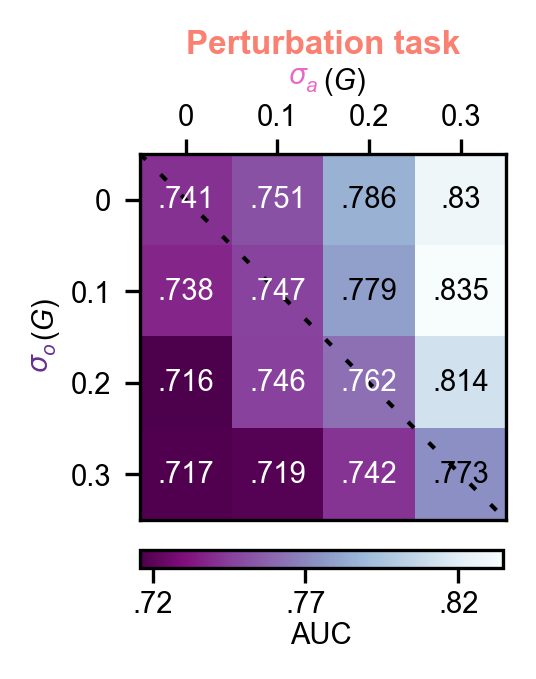

In [41]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = auc_noise_pert_mean_ho

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Perturbation task', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.72, 0.77, 0.82]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    #rect = Rectangle(xy=(1.5, 0.5), width=1, height=1, fill=False, ec='k', lw=1)
    #ax.add_patch(rect)
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_pert_ho'), orientation='portrait', format='pdf', transparent=True)

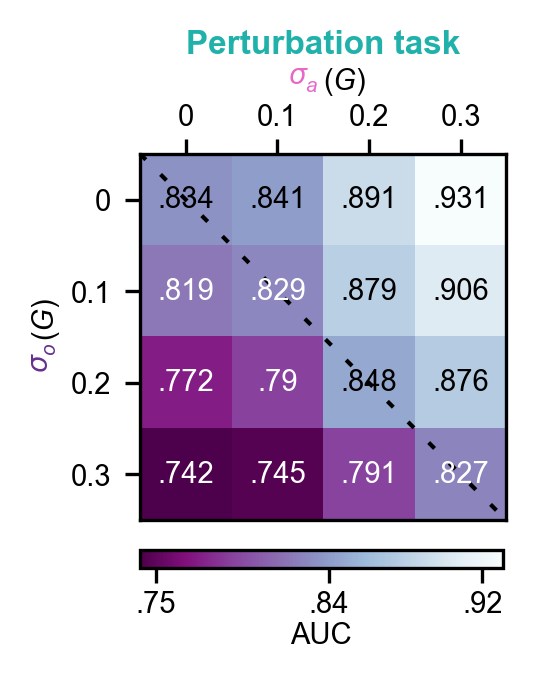

In [42]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = auc_noise_pert_mean_mo

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Perturbation task', fontsize=fontsize + 1, fontweight='bold', pad=3, c=modular_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.75, 0.84, 0.92]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    #rect = Rectangle(xy=(1.5, 0.5), width=1, height=1, fill=False, ec='k', lw=1)
    #ax.add_patch(rect)
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_pert_mo'), orientation='portrait', format='pdf', transparent=True)

## S7b

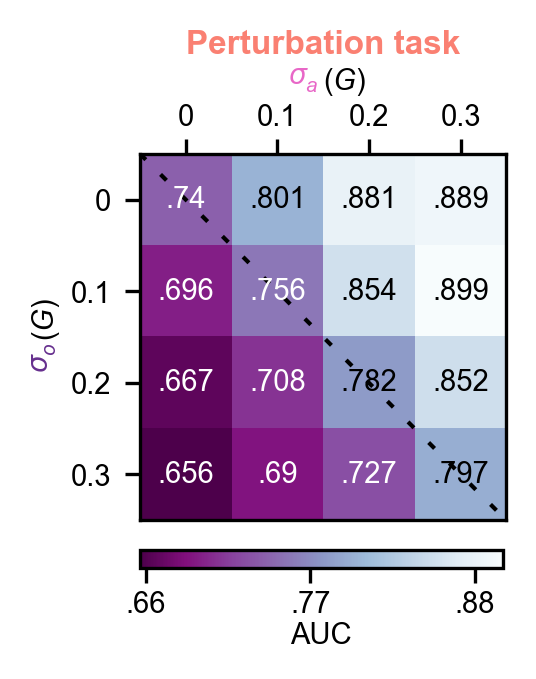

In [43]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = auc_noise_pert_mean_ho_L

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Perturbation task', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.66, 0.77, 0.88]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    #rect = Rectangle(xy=(1.5, 0.5), width=1, height=1, fill=False, ec='k', lw=1)
    #ax.add_patch(rect)
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_pert_hoL'), orientation='portrait', format='pdf', transparent=True)

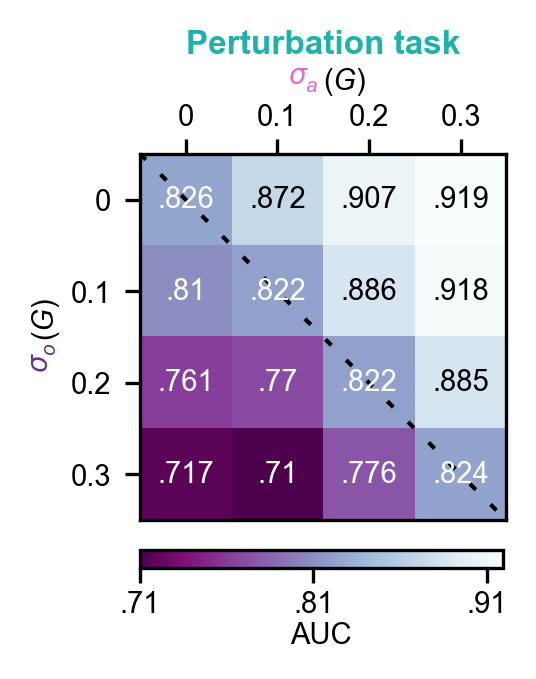

In [44]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = auc_noise_pert_mean_mo_L

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Perturbation task', fontsize=fontsize + 1, fontweight='bold', pad=3, c=modular_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.71, 0.81, 0.91]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    #rect = Rectangle(xy=(1.5, 0.5), width=1, height=1, fill=False, ec='k', lw=1)
    #ax.add_patch(rect)
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_pert_moL'), orientation='portrait', format='pdf', transparent=True)

## S7c

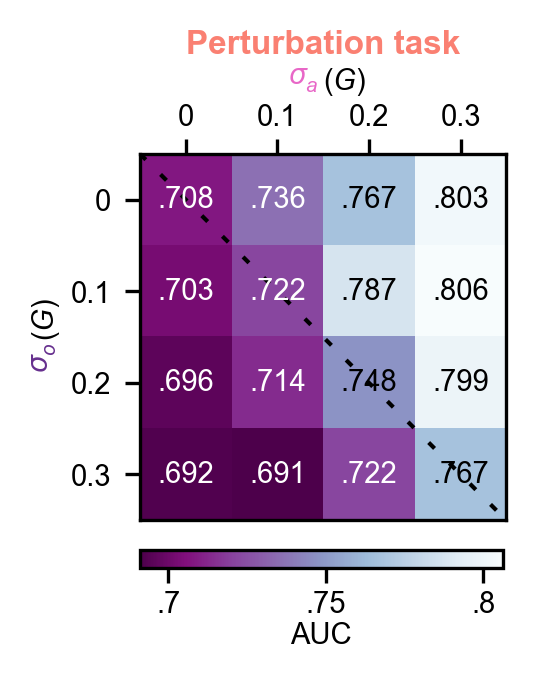

In [45]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = auc_noise_pert_mean_ho_LH

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Perturbation task', fontsize=fontsize + 1, fontweight='bold', pad=3, c=holistic_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.7, 0.75, 0.8]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    #rect = Rectangle(xy=(1.5, 0.5), width=1, height=1, fill=False, ec='k', lw=1)
    #ax.add_patch(rect)
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_pert_hoLH'), orientation='portrait', format='pdf', transparent=True)

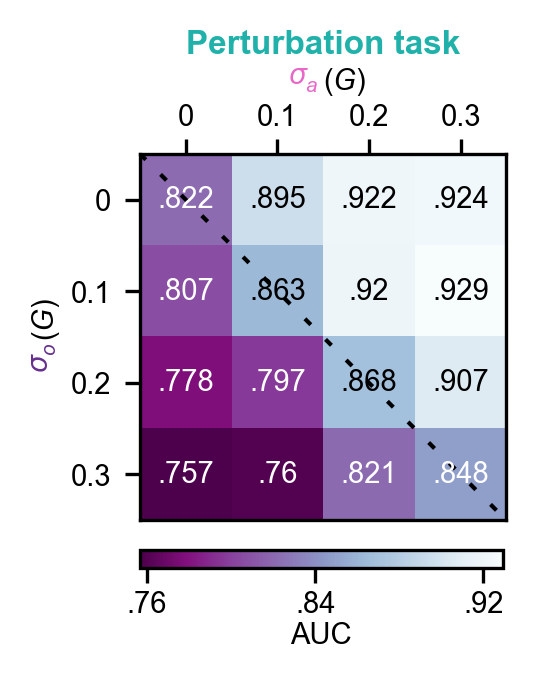

In [46]:
xticks = np.arange(len(obs_stds)); xticklabels = obs_stds
yticks = np.arange(len(pro_stds)); yticklabels = pro_stds
width = 1.7
height = 2.2
data = auc_noise_pert_mean_mo_LH

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Perturbation task', fontsize=fontsize + 1, fontweight='bold', pad=3, c=modular_c)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, yticklabels, fontsize=fontsize)
    ax.set_xlabel(r'$\sigma_a$', fontsize=fontsize, c=motor_c)
    ax.set_ylabel(r'$\sigma_o$', fontsize=fontsize, c=sensory_c)
    ax.xaxis.set_label_coords(0.445, 1.24)
    ax.yaxis.set_label_coords(-0.22, 0.445)
        
    cmatplot = ax.matshow(data, cmap='BuPu_r') 
    ax.tick_params(axis='x', which='major', pad=2, bottom=False)
    cbaxes = ax.inset_axes([0, -0.13, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.76, 0.84, 0.92]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.9)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    #rect = Rectangle(xy=(1.5, 0.5), width=1, height=1, fill=False, ec='k', lw=1)
    #ax.add_patch(rect)
    ax.plot([-0.5, 3.5], [-0.5, 3.5], lw=lw, c='k', ls=(0, (2, 5)))
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            v = round(data[iy][ix], 3)
            c = 'k' if v > np.mean(data) else 'w' 
            ax.text(x, y, s='.' + str(v).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    ax.text(1.5, -1.2, '$(G)$', fontsize=fontsize)
    ax.text(-1.7, 1.45, '$(G)$', fontsize=fontsize, rotation='vertical')
    
    fig.tight_layout(pad=0.3, rect=(-0.01, 0.02, 0.99, 1.02))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_pert_moLH'), orientation='portrait', format='pdf', transparent=True)

## 7c-d

In [47]:
res_ho_EKF_pert, res_ho_EKF_shuffle_pert = bootstrap_corr(auc_noise_pert_mean_ho, corr_ho_EKF)
res_ho_EKFA_pert, res_ho_EKFA_shuffle_pert = bootstrap_corr(auc_noise_pert_mean_ho, corr_ho_EKF_control)
res_mo_EKF_pert, res_mo_EKF_shuffle_pert = bootstrap_corr(auc_noise_pert_mean_mo, corr_mo_EKF)
res_mo_EKFA_pert, res_mo_EKFA_shuffle_pert = bootstrap_corr(auc_noise_pert_mean_mo, corr_mo_EKF_control)

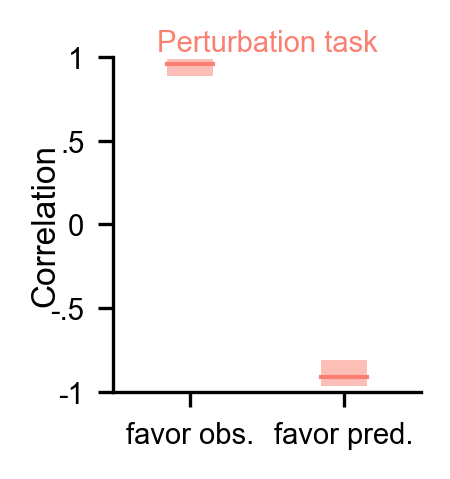

In [48]:
width = 1.3; height = 1.4
yticks = np.around(np.linspace(-1, 1, 5), 1)
ydata1 = [res_ho_EKF_pert, res_ho_EKFA_pert]
ydata2 = [res_ho_EKF_shuffle_pert, res_ho_EKFA_shuffle_pert]
colors = [holistic_c, holistic_c]

xticks = np.arange(2)
xticklabels = ['favor obs.', 'favor pred.']

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.set_title('Perturbation task', fontsize=fontsize, pad=0, c=holistic_c)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Correlation', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.17, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ydata, c in zip(xticks, ydata1, colors):
    ymean = ydata.bootstrap_distribution.mean()
    ax.plot([x-0.15, x+0.15], [ymean, ymean], c=c, lw=lw)
    ax.fill_between([x-0.15, x+0.15], [ydata.confidence_interval.low] * 2, [ydata.confidence_interval.high] * 2, 
                    facecolor=c, alpha=0.5)    
    
#ax.text(-0.2, 0, 'Shuffled', fontsize=fontsize - 0.5, c='gray')
    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='generalization_Kalman_ho_pert'), orientation='portrait', format='pdf', transparent=True)

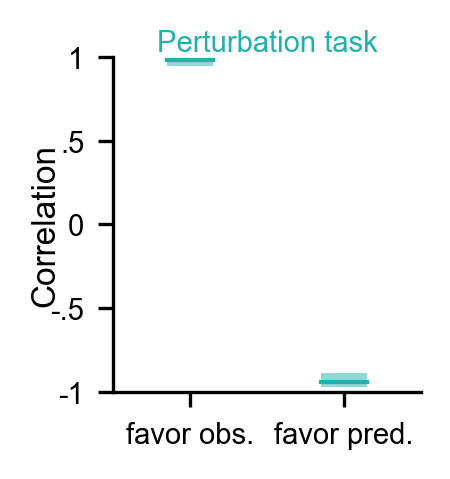

In [49]:
width = 1.3; height = 1.4
yticks = np.around(np.linspace(-1, 1, 5), 1)
ydata1 = [res_mo_EKF_pert, res_mo_EKFA_pert]
ydata2 = [res_mo_EKF_shuffle_pert, res_mo_EKFA_shuffle_pert]
colors = [modular_c, modular_c]

xticks = np.arange(2)
xticklabels = ['favor obs.', 'favor pred.']

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.set_title('Perturbation task', fontsize=fontsize, pad=0, c=modular_c)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Correlation', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.17, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ydata, c in zip(xticks, ydata1, colors):
    ymean = ydata.bootstrap_distribution.mean()
    ax.plot([x-0.15, x+0.15], [ymean, ymean], c=c, lw=lw)
    ax.fill_between([x-0.15, x+0.15], [ydata.confidence_interval.low] * 2, [ydata.confidence_interval.high] * 2, 
                    facecolor=c, alpha=0.5)    
    
#ax.text(-0.2, 0, 'Shuffled', fontsize=fontsize - 0.5, c='gray')
    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='generalization_Kalman_mo_pert'), orientation='portrait', format='pdf', transparent=True)